In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
data_dir = '../test_data/patches_10x_256x256'
import os
import PIL
from os.path import join as j
import PIL.Image as Image

img_path = j(data_dir, os.listdir(data_dir)[0])
print(img_path)
img = Image.open(img_path).convert('RGB')

../test_data/patches_10x_256x256/BD2021_00000508__2021-01-28_02.34.50_x_17088_y_53952.png


In [6]:
import torch
import torchvision.transforms.functional as F
import numpy as np
delta_b = 64/255
delta_s = 0.25
delta_h = 0.04
delta_c = 0.75

z = []

def generate_z(keys = ['brightness', 'contrast', 'saturation', 'hue', 'hflip', 'vflip'],
               range_args: dict = {}, bsize = 1, seed=None) -> torch.Tensor:
    z = []
    if seed:
        np.random.seed(seed)
    for key in keys:
        if key in ['hflip', 'vflip']:
            z.append(np.random.randint(2, size=bsize))
        elif key in ['brightness', 'saturation', 'contrast']:
            if key in range_args.keys():
                jitter_range = [max(0, 1 - range_args[key]), 1 + range_args[key]]
            else:
                jitter_range = [0, 2]
            scale = jitter_range[1] - jitter_range[0]
            shift = jitter_range[0]
            z.append(scale * np.random.random(size = bsize) + shift)
        elif key == 'hue':
            if key in range_args.keys():
                jitter_range = [-range_args[key], range_args[key]]
            else:
                jitter_range = [-0.5, 0.5]
            scale = jitter_range[1] - jitter_range[0]
            shift = jitter_range[0]
            z.append(scale * np.random.random(size = bsize) + shift)
    return np.stack(z, axis=1)

class CustomTransform:
    """Rotate by one of the given angles."""

    def __init__(self, keys):
        self.keys = keys
#         self.fmap = {'brightness': F.adjust_brightness,
#                 'contrast': F.adjust_contrast,
#                 'saturation': F.adjust_saturation,
#                 'hue': F.adjust_hue}

    def __call__(self, img, z):
        assert len(z.reshape(-1)) == len(self.keys) 
        for idx, key in enumerate(self.keys):
            if key == 'brightness':
                img = F.adjust_brightness(img, z[idx])
            elif key == 'contrast':
                img = F.adjust_contrast(img, z[idx])
            elif key == 'saturation':
                img = F.adjust_saturation(img, z[idx])
            elif key == 'hue': 
                img = F.adjust_hue(img, z[idx])
            elif key == 'hflip':
                if z[idx] > 0:
                    img = F.hflip(img)
            elif key == 'vflip':
                if z[idx] > 0:
                    img = F.vflip(img)
        return img




        

In [7]:
# default range
keys = ['brightness', 'saturation', 'hue', 'contrast', 'hflip', 'vflip']
z = generate_z(keys = keys, bsize=1)
z

array([[ 1.90772808,  0.29840051, -0.38594544,  0.30646116,  1.        ,
         1.        ]])

In [8]:
range_args = {'brightness': 64/255,
              'saturation': 0.25,
              'hue': 0.04,
              'contrast': 0.75}
keys = ['brightness', 'saturation', 'hue', 'contrast', 'hflip', 'vflip']
tf = CustomTransform(keys)
zs = generate_z(keys = keys, bsize=8, range_args = range_args)
zs.reshape(-1)

import torchvision.transforms.functional as F
import torchvision.transforms as T
def get_transforms(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)):
    trnsfrms = T.Compose([T.ToTensor(), 
                          T.Normalize(mean=mean, std=std)])

    return trnsfrms

array([ 1.09736162,  0.94653203, -0.01053065,  1.54839842,  1.        ,
        1.        ,  1.174265  ,  0.93084652, -0.03412851,  1.0670162 ,
        1.        ,  1.        ,  0.7924563 ,  1.10591668, -0.02159805,
        1.27660945,  1.        ,  1.        ,  0.87726978,  0.92584058,
       -0.0219168 ,  1.16951527,  0.        ,  1.        ,  0.99775231,
        1.18480686,  0.01619632,  0.88859069,  0.        ,  0.        ,
        1.19962383,  1.0057049 , -0.02332841,  1.60358754,  0.        ,
        0.        ,  0.94614725,  1.09481363, -0.00570716,  1.59512078,
        0.        ,  0.        ,  1.03107945,  1.04427556, -0.03553884,
        1.71098734,  1.        ,  1.        ])

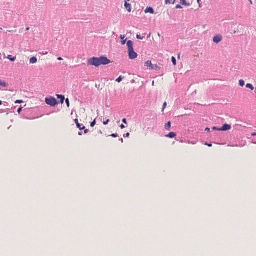

[ 1.09736162  0.94653203 -0.01053065  1.54839842  1.          1.        ]


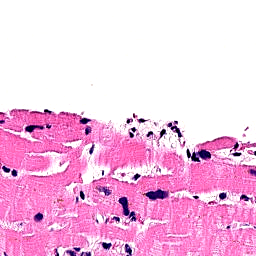

torch.Size([3, 256, 256])

[ 1.174265    0.93084652 -0.03412851  1.0670162   1.          1.        ]


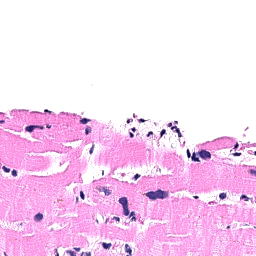

torch.Size([3, 256, 256])

[ 0.7924563   1.10591668 -0.02159805  1.27660945  1.          1.        ]


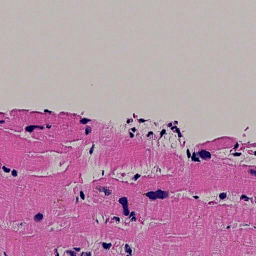

torch.Size([3, 256, 256])

[ 0.87726978  0.92584058 -0.0219168   1.16951527  0.          1.        ]


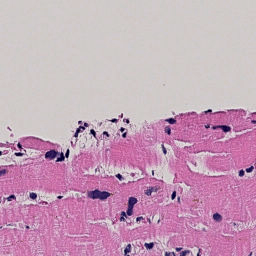

torch.Size([3, 256, 256])

[0.99775231 1.18480686 0.01619632 0.88859069 0.         0.        ]


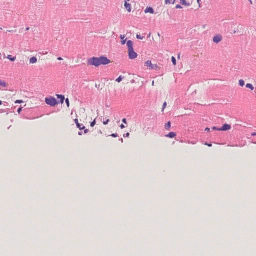

torch.Size([3, 256, 256])

[ 1.19962383  1.0057049  -0.02332841  1.60358754  0.          0.        ]


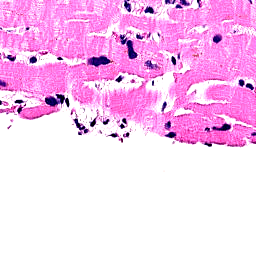

torch.Size([3, 256, 256])

[ 0.94614725  1.09481363 -0.00570716  1.59512078  0.          0.        ]


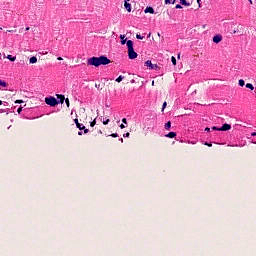

torch.Size([3, 256, 256])

[ 1.03107945  1.04427556 -0.03553884  1.71098734  1.          1.        ]


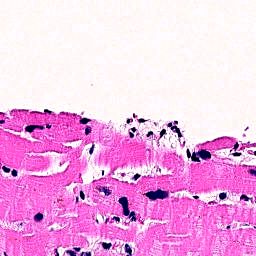

torch.Size([3, 256, 256])

In [9]:
default_tf = get_transforms()
img
for z in zs:
    print(z)
    img_t = tf(img, z)
    img_t
    default_tf(img_t).shape